In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### wine reviews<br>
country - The country that the wine is from <br>
designation - The vineyard within the winery where the grapes that made the wine are from<br>
points - The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)<br>
price - The cost for a bottle of the wine<br>
province - The province or state that the wine is from<br>
region_1 - The wine growing area in a province or state (ie Napa)<br>
region_2 - Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank<br>
taster_name<br>
taster_twitter_handle<br>
title - The title of the wine review, which often contains the vintage if you're interested in extracting that 
feature<br>
variety - The type of grapes used to make the wine (ie Pinot Noir)<br>
winery - The winery that made the wine<br>

In [200]:
df = pd.read_csv('../data/winemag-data_first150k.csv')

In [201]:
df = df.dropna()

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 0 to 150916
Data columns (total 11 columns):
Unnamed: 0     39241 non-null int64
country        39241 non-null object
description    39241 non-null object
designation    39241 non-null object
points         39241 non-null int64
price          39241 non-null float64
province       39241 non-null object
region_1       39241 non-null object
region_2       39241 non-null object
variety        39241 non-null object
winery         39241 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 3.6+ MB


In [203]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


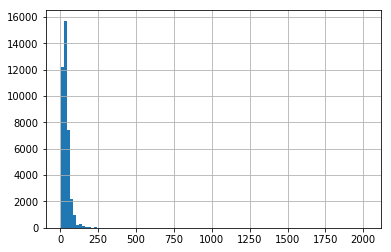

In [204]:
df['price'].hist(bins=100);

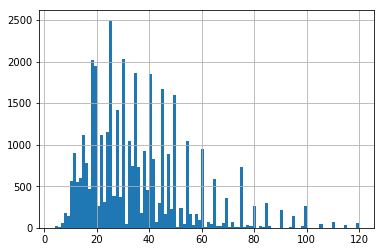

In [205]:
df[df['price'] < df['price'].quantile(0.99)]['price'].hist(bins=100);

In [206]:
df['price'].mean(), df['price'].median()

(37.54631635279427, 32.0)

In [207]:
threshold = df['price'].median()
df['is_swag'] = df['price'].apply(lambda x: 1 if x > threshold else 0)

In [208]:
df[df['is_swag'] == 1].shape, df[df['is_swag'] == 0].shape

((19278, 12), (19963, 12))

## Доверительные интервалы для доли

На основе той же самой нормальной аппроксимации
$$\hat{p}\pm z_{1-\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}}$$

In [209]:
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm

In [211]:
for province in df['province'].unique():
    df_prop = df[df['province'] == province]
    prop = sum(df_prop['is_swag']) / len(df_prop)
    print('proportion swag wines in {0} is {1}'.format(province,prop))

proportion swag wines in California is 0.5257905242147284
proportion swag wines in Oregon is 0.5805070793546263
proportion swag wines in Washington is 0.3753675269519765
proportion swag wines in New York is 0.13245901639344262


In [212]:
for province in df['province'].unique():
    df_prop = df[df['province'] == province]
    prop = sum(df_prop['is_swag']) / len(df_prop)
    prop_int = proportion_confint(sum(df_prop['is_swag']),len(df_prop),alpha=0.05,method='normal')
    print('interval of proportion swag wines in {0} is {1}'.format(province,prop_int))

interval of proportion swag wines in California is (0.5199991278163051, 0.5315819206131517)
interval of proportion swag wines in Oregon is (0.5629564872321101, 0.5980576714771425)
interval of proportion swag wines in Washington is (0.36323805046059787, 0.38749700344335514)
interval of proportion swag wines in New York is (0.11544531006168147, 0.1494727227252038)


In [213]:
#посчитано ручками по формуле выше
z=norm.ppf(1 - 0.05 / 2)
prop-z*np.sqrt((prop*(1-prop))/len(df_prop)) , prop + z*np.sqrt((prop*(1-prop))/len(df_prop))

(0.11544531006168147, 0.1494727227252038)

## Доверительные интервалы для средних

Нормальная аппроксимация
$$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [214]:
from statsmodels.stats.weightstats import _tconfint_generic

In [216]:
swag_mean_points = df[df['is_swag'] == 1]['points'].mean()
swag_mean_std = df[df['is_swag'] == 1]['points'].std()/np.sqrt(len(df[df['is_swag'] == 1]['points']))

cheap_mean_points = df[df['is_swag'] == 0]['points'].mean()
cheap_mean_std = df[df['is_swag'] == 0]['points'].std()/np.sqrt(len(df[df['is_swag'] == 0]['points']))

In [217]:
swag_mean_points, cheap_mean_points

(89.88141923436041, 86.89074788358464)

In [218]:
swag_interval = _tconfint_generic(swag_mean_points, swag_mean_std, len(df[df['is_swag'] == 1]['points']) - 1,\
                                  0.01,alternative='two-sided')
cheap_interval = _tconfint_generic(cheap_mean_points, cheap_mean_std, len(df[df['is_swag'] == 0]['points']) - 1,\
                                   0.01,alternative='two-sided')


In [219]:
print(swag_interval)
print(cheap_interval)

(89.82045903531103, 89.94237943340978)
(86.83783303611764, 86.94366273105163)


## Bootstrap

<img src="../img/bootstrap.png" alt="lokh" height="400" width="500">


Метод бутстрэпа заключается в следующем. Пусть имеется выборка X размера N и есть некая статистика, например
медиана.  Из исходной выборки мы можем выбирать N объектов с возвращением. Это означает что мы 
будем N раз брать произвольный объект из выборки с одинаковой вероятностью 1/N. Таким образом мы можем получить
какое то количество bootstrap выборок и на основе их посчитать нашу статитику и тогда получим bootstrap
распределение нашей статистики. Некий способ получить практическое распределение нужной нам статистики.

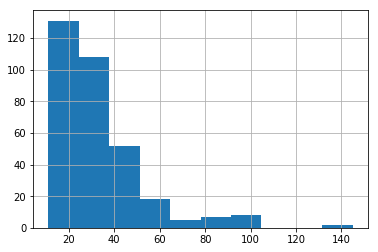

In [220]:
df[df['region_1'] == 'Livermore Valley']['price'].hist();

In [222]:
df[df['region_1'] == 'Livermore Valley']['price'].shape

(331,)

In [221]:
df[df['region_1'] == 'Livermore Valley']['price'].median()

27.0

In [223]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [224]:
np.random.seed(17)

median_region_prices = list(map(np.median,get_bootstrap_samples(df[df['region_1'] == 'Livermore Valley']['price'].values,10000)))


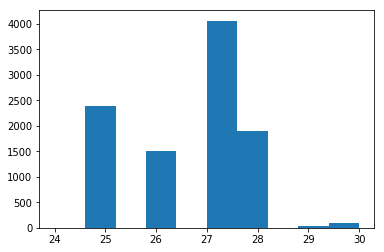

In [225]:
plt.hist(median_region_prices);

In [226]:
stat_intervals(median_region_prices,0.05)

array([25., 28.])